In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import performance

## Gap Trading Signal

### Introduction

**The idea of this strategy is to chase the momentum in a financial market where information dissipates not all at once.**
For example, after a strong earnings report, a single stock can open at a very high level on the next trading day compared to the closing price from the previous trading day. We observe that this uptick continues throughout the next trading day. Therefore, there are opportunities for traders to take advantage of.

In this project, our trading universe is 100 stocks from S&P 100 index (excluding META due to data quality issues), between 2010-01-04 and 2022-12-30.

Further research are performed on **optimal lookback window, optimal holding period, optimal portfolio construction, max profit/loss threshold, inverse signals**, etc. 

### Methodology
**Formally, the strategy generates a buy signal for a single stock when the gap between open price at trading day t and close price at trading day t-1 is considered significant over a fixed period of rolling look back window.** A mathematical explanation of a gap being "significant" is as follows,<br><br>

*Consider a fixed-length rolling look back window $W$= 50 trading days. The open gap $gap_{t,i}$ for stock $i$ is defined as<br><br>
$$
gap_{t,i} = S_{open,t,i} - S_{Close,t-1,i},
$$<br>
where $S_{open,t,i}$ is the open price of stock $i$ at trading day t, and $S_{Close,t-1,i}$ is the close price of stock $i$ at trading day t-1.<br><br>
For stock $i$, we obtain a time series $G_{i}$ = {$gap_{s-49,i}$, $gap_{s-48,i}$, $gap_{s-47,i}$,..., $gap_{s,i}$}, where $s$ corresponds to the last trading day in the look back window $W$.
For a significance level of 90%, $gap_{s,i}$ is considered significant if and only if $gap_{s,i}$ is at least in the 90th-percentile of $G_{i}$. Under this case, our strategy will generate a buy signal for stock $i$ on trading day $s$ at open. Since $gap_{s,i}$ is available information on trading day $s$ as soon as market opens, this strategy does not have look ahead bias.*<br>

**Following a buy signal, we enter a long position of stock $i$ at open, and close the position before the trading session ends.** In other words, the most possible holding period for this strategy is one trading day, as we try to avoid position overlay in the next trading day. The rationale is simple and straightforward. Consider a scenario where we decide not to clsoe the position of 10 shares of AAPL following a buy signal after the trading session ends, and there is another buy signal for AAPL on the next trading day. Given that we currently have a positive position in AAPL, do we buy more shares of AAPL as the signal suggests? If so, how much more capital should we allocate to AAPL? If we do not buy more shares, and there is a signal for a different stock on the same day, how should we construct an equal-weight portfolio? To avoid spending further resources on these questions, we can simply decide that we must close out our position at the end of trading session and only hold cash overnight. 

**The holding period can vary from 15 minutes to one trading session, depending on empirical results.** In this project, we explore different holding periods and see on average if there is an optimal exit time for this strategy. This is borrowing an intraday return framework in a previous project of mine, with details here: https://github.com/shaoyuliu98/Quantitative-Research/blob/26f7677be1b767446ae0b9a3fb5aa0ee6189f845/Intraday%20Return%20Analysis.ipynb. We try to see if applying a signal will vastly improve the empirical results. We also apply other classic exit signals such as SMA crossovers in combination with the analysis above, hoping to optimize the trading strategy without overfitting.

**Also note that for a trading day where signals for multiple stocks exist, we simply construct an equal weight portfolio.** For example, if there is a signal for AAPL on Mar 23rd, 2023, we will allocate \\$100 dollars on AAPL shares; if there are signals for both AAPL and TSLA on Mar 23rd, 2023, we will allocate \\$50 dollars in each stock, with total capital allocation of \\$100 dollars on that day. Therefore, on any given day, the strategy's return is the average return of the securities with signals. We also explore other options such as fixed capital allocation (e.g., assign a fixed size for each signal, regardless of how many signals are present on any given day), mean-variance and maximum sharpe, but the main focus of this project is on signal generation and optimal exit strategy.

### Signal Generation
**The below example is signals generated using the parameters mentioned above, namely a look back window of 50 trading days and a siginificance level of 90%.** 1 represents a buy signal, and 0 represents no action. The rows indicate any date where a trading signal is generated, and columns correspond to the tickers in our trading universe.

In [2]:
signals = pd.read_csv('./signals/Open Gap Signals/SP 100/sp100_signal_50rolling_90lvl.csv')

In [3]:
# drop META due to data quality issues
selected = [i for i in signals.columns if i!='META']
signals = signals[selected]
signals.set_index('Date',inplace=True)
# drop any days without signals (coming from META)
signals = signals.loc[~(signals==0).all(axis=1)]

signals.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2010-03-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Signal Characteristics
**We plot the heatmap for all signals generated in 2022 as an example.** Baige areas indicate buy signals, whereas black areas indicate no trading activities. An interesting observation is that we see certain dates where there is a buy signal for most stocks in our trading universe, such as Mar 9, Oct 18, Nov 10, and Dec 13, all of which have at least 85 buy signals out of 100 stocks. This massive scale of signals indicates that there must have been some positive macroeconomic news overnight or before the opening bell that drives the market in the upward direction. 

For instance, CPI data was released in the morning of November 10th, 2022, just ahead of market open, and the results were better than expected in October. This suggested that the pressure from inflation could be starting to "cool down", thus creating a positive sentiment around the market, as S&P 500 opened over 3% higher. See full story and news release from CNBC: https://www.cnbc.com/2022/11/10/consumer-prices-rose-0point4percent-in-october-less-than-expected-as-inflation-eases.html.

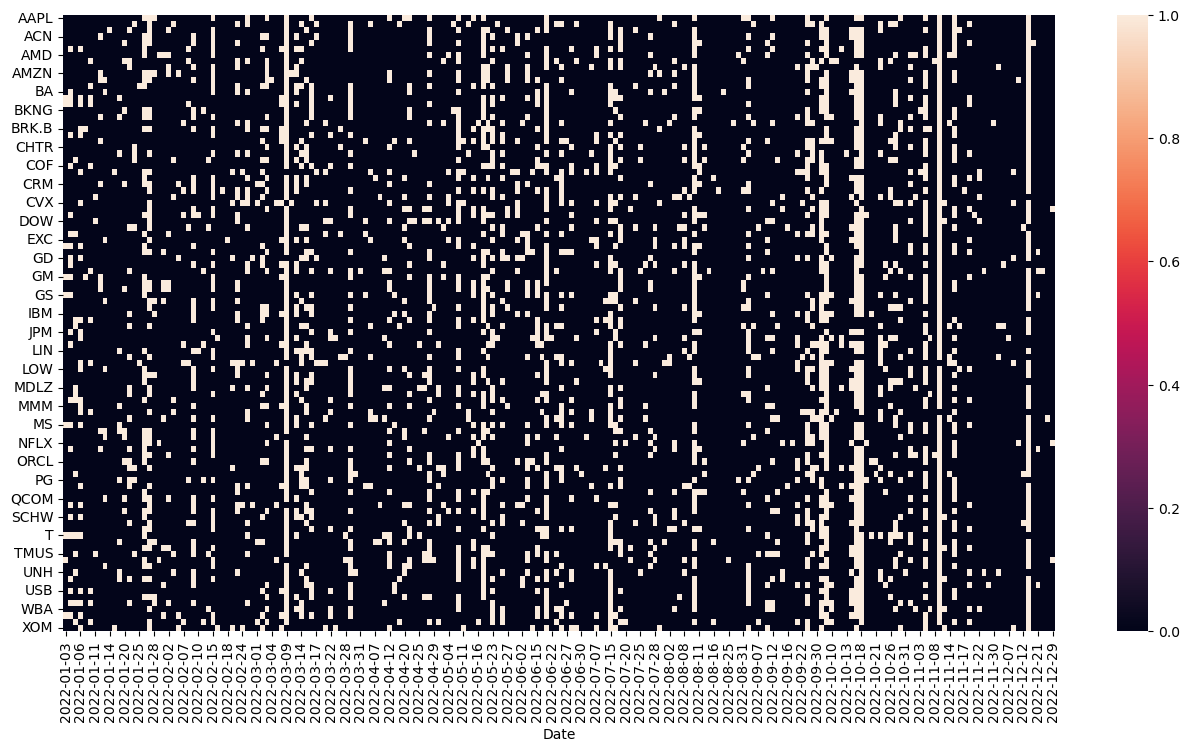

In [4]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(signals.loc['2022-01-01':'2022-12-31',:].T)
plt.show()

**We also plot the total number of trades by month to see if there is a seasonality effect.** As the chart below suggests, we see peaks appear around Jan, Mar, Jun, and Oct, all around or before earnings season. This makes a lot of economic sense because there will likely be some changes in these companies' fundamental values as earnings come out, thus shifting their corresponding "fair price" in the market. 

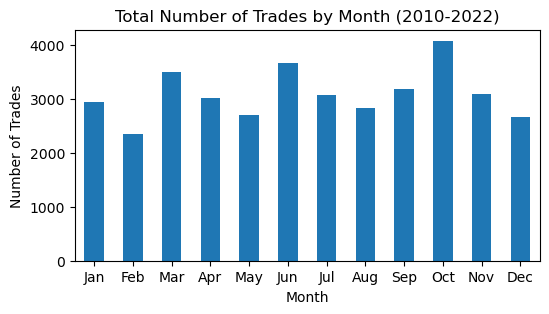

In [5]:
fig, ax = plt.subplots(figsize=(6,3))
signals.groupby(pd.to_datetime(signals.index).month).sum().sum(axis=1).plot.bar(ax=ax)
plt.title('Total Number of Trades by Month (2010-2022)')
plt.xlabel('Month')
plt.ylabel('Number of Trades')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=0)
plt.show()

**We analyze the frequency of signals as well.** In aggregate, we calculate the percentage of time we are in the market by taking the delta of two nearest trading days with at least one signals. The table and graph below suggest that we are actively trading in the market, with 8 days being the largest gap without any trading activities.

Summary Statistics:
----  ----
mean  1.67
min   1
max   8
----  ----


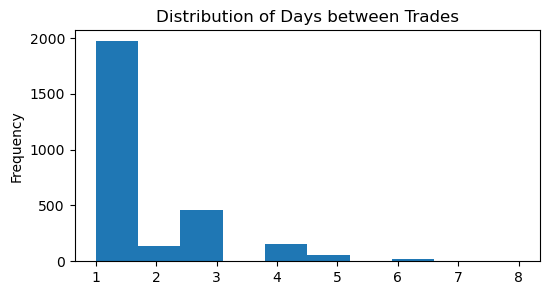

In [6]:
dist_trade_break = pd.to_datetime(pd.Series(signals.index)).diff().apply(lambda x:x.days)

print('Summary Statistics:')
print(tabulate(pd.DataFrame(dist_trade_break.describe().loc[['mean','min','max']].round(2))))

dist_trade_break.plot.hist(figsize=(6,3))
plt.title('Distribution of Days between Trades')
plt.show()

**A few more summary statistics about this particular gap trading signal.**

In [7]:
signal_sum = pd.DataFrame()

signal_sum['Trades Per Year'] = signals.groupby(pd.to_datetime(signals.index).year).sum().sum(axis=1)
signal_sum['Trades Per Month'] = (signal_sum['Trades Per Year']/12).round(2)
signal_sum['Trades Per Day'] = (signal_sum['Trades Per Year']/250).round(2)
signal_sum['Most Traded Security'] = signals.groupby(pd.to_datetime(signals.index).year).sum().idxmax(axis=1)+'('+signals.groupby(pd.to_datetime(signals.index).year
                                                                                                                                 ).sum().max(axis=1).astype(int).astype(str)+')'
signal_sum['Least Traded Security'] = signals.groupby(pd.to_datetime(signals.index).year).sum().idxmin(axis=1)+'('+signals.groupby(pd.to_datetime(signals.index).year
                                                                                                                                 ).sum().min(axis=1).astype(int).astype(str)+')'
signal_sum.reset_index(inplace=True)
signal_sum.rename({'Date':'Year'},axis=1,inplace=True)

signal_tot = pd.DataFrame(['Total',signal_sum['Trades Per Year'].sum(),np.nan,np.nan, 
                            signals.sum().idxmax()+'('+str(int(signals.sum().max()))+')',
                            signals.sum().idxmin()+'('+str(int(signals.sum().min()))+')'],index=signal_sum.columns).T

signal_sum = pd.concat([signal_sum,signal_tot])

print(tabulate(signal_sum,headers=signal_sum.columns,showindex=False,tablefmt='rst',numalign='center',stralign='center'))

======  =================  ==================  ================  ======================  =======================
 Year    Trades Per Year    Trades Per Month    Trades Per Day    Most Traded Security    Least Traded Security
======  =================  ==================  ================  ======================  =======================
 2010         2086               173.83              8.34               NFLX(38)                 ABBV(0)
 2011         2943               245.25             11.77               BKNG(39)                 ABBV(0)
 2012         2330               194.17              9.32               AAPL(39)                 ABBV(0)
 2013         2950               245.83              11.8                BA(39)                  DOW(0)
 2014         2974               247.83              11.9               MRK(40)                  DOW(0)
 2015         2824               235.33              11.3               AMZN(36)                 DOW(0)
 2016         2946               24

### Signal Performance
**After we have generated signals, the next natural step is to evaluate the performance.** To start, we simply hold every asset until 15 minutes before market close for all trading activities. To put it in another word, we buy the stock at open when there is a signal, and we close the position at 15:45. For days where multiple signals exist, we construct an equal weight portfolio (i.e., strategy daily return = avg return of all securities traded). The decision of 15 minutes before market close is drawn from previous research mentioned above on typical intraday price action movement.

In [8]:
pnl = pd.read_csv('./pnl/Open Gap Pnl/SP 100/sp100_pnl_50rolling_90lvl.csv',index_col=0)
pnl = pnl.reset_index().rename({'index':'Date'},axis=1)
pnl = pnl.loc[pnl['Ticker']!='META']

In [24]:
close_pnl = pnl.loc[pnl['Time']=='15:30'].dropna()
print('15 Sample Trades')
print(tabulate(close_pnl[['Date','Signal','Strat_Pnl','Ticker']].sample(15).sort_values('Date').round(4),headers=['Date','Signal','Strat_Pnl','Ticker'],
               showindex=False,tablefmt='rst',numalign='center',stralign='center'))

15 Sample Trades
==========  ========  ===========  ========
   Date      Signal    Strat_Pnl    Ticker
==========  ========  ===========  ========
2010-10-15     1        0.0145       GILD
2012-04-17     1        0.0115       UNH
2012-05-10     1        -0.0024      WMT
2012-07-26     1        0.0241       NKE
2014-03-21     1        -0.0001      DHR
2015-04-01     1        0.0036       AMT
2015-04-20     1        -0.0047      AIG
2016-03-01     1        -0.0004      CVS
2016-04-19     1        0.0081       JNJ
2018-08-16     1        -0.0072      PYPL
2019-06-04     1        -0.0111       VZ
2020-01-10     1        -0.0046      MDLZ
2020-11-03     1        0.0012       AIG
2022-09-02     1        -0.0187      KHC
2022-11-15     1        -0.0098      AMD
==========  ========  ===========  ========


**We plot PnL and other performance metrics as a reference.** An immediate reaction to **this strategy (50 days rolling window + 90% sigfinicance level + Holding to close + Equal Weight Portfolio)** is that it works well for some regimes (such as 2010 to 2011), but does not work at all for other regimes (long drawdown period between 2012 and 2016).

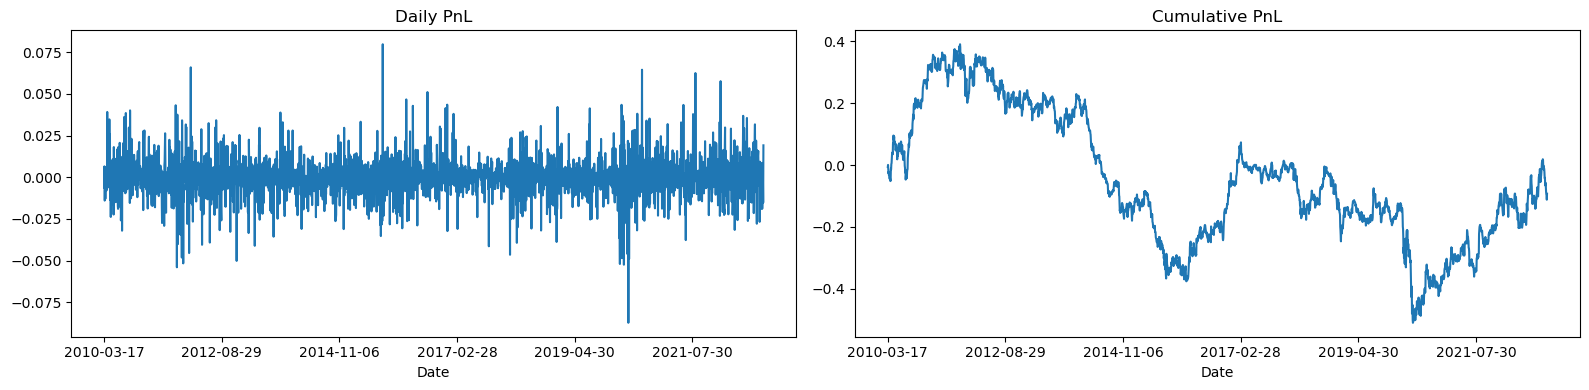

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,4),sharex=True)
close_pnl.groupby(['Date'])['Strat_Pnl'].mean().plot(ax=ax[0])
close_pnl.groupby(['Date'])['Strat_Pnl'].mean().cumsum().plot(ax=ax[1])
ax[0].set_title('Daily PnL')
ax[1].set_title('Cumulative PnL')
plt.tight_layout()
plt.show()

**To validate the point earlier on regimes, we compare the performance metrics of the same strategy but in different time spans.** We see that this strategy does work well during 2010-2011, 2016-2017, and after June 2020, but did not perform well in other periods. In addition to a potential conclusion that this strategy is heavily susceptible to different regimes, the results also raise the idea that it might take the market less than a trading day to adjust and absorb new information, and we might want to close out the position an even larger amount of time before the market close in order to capture any sustainable profits.

In [38]:
close_pnl_ret = close_pnl.groupby(['Date'])['Strat_Pnl'].mean().reset_index().rename({'Date':'date','Strat_Pnl':'return'},axis=1)
close_pnl_ret['date'] = pd.to_datetime(close_pnl_ret['date'])

close_pnl_strat_all = performance.Trading_Strategy(close_pnl_ret)
close_pnl_strat_all_metrics = close_pnl_strat_all.get_metrics().rename({'Value':'Overall'},axis=1)

close_pnl_strat_lt2012 = performance.Trading_Strategy(close_pnl_ret.loc[close_pnl_ret['date']<'2012-01-01'])
close_pnl_strat_lt2012_metrics = close_pnl_strat_lt2012.get_metrics().rename({'Value':'Time Span 1'},axis=1)

close_pnl_strat_lt2016 = performance.Trading_Strategy(close_pnl_ret.loc[(close_pnl_ret['date']>='2012-01-01')&(close_pnl_ret['date']<'2016-01-01')])
close_pnl_strat_lt2016_metrics = close_pnl_strat_lt2016.get_metrics().rename({'Value':'Time Span 2'},axis=1)

close_pnl_strat_lt2018 = performance.Trading_Strategy(close_pnl_ret.loc[(close_pnl_ret['date']>='2016-01-01')&(close_pnl_ret['date']<'2018-01-01')])
close_pnl_strat_lt2018_metrics = close_pnl_strat_lt2018.get_metrics().rename({'Value':'Time Span 3'},axis=1)

close_pnl_strat_lt2020Jun = performance.Trading_Strategy(close_pnl_ret.loc[(close_pnl_ret['date']>='2018-01-01')&(close_pnl_ret['date']<='2020-06-01')])
close_pnl_strat_lt2020Jun_metrics = close_pnl_strat_lt2020Jun.get_metrics().rename({'Value':'Time Span 4'},axis=1)

close_pnl_strat_rest = performance.Trading_Strategy(close_pnl_ret.loc[(close_pnl_ret['date']>='2020-06-01')])
close_pnl_strat_rest_metrics = close_pnl_strat_rest.get_metrics().rename({'Value':'Time Span 5'},axis=1)

print(tabulate(pd.concat([close_pnl_strat_all_metrics,close_pnl_strat_lt2012_metrics,close_pnl_strat_lt2016_metrics,
                          close_pnl_strat_lt2018_metrics, close_pnl_strat_lt2020Jun_metrics,close_pnl_strat_rest_metrics],
                         axis=1),headers='keys', tablefmt='rst',stralign='center'))

=====================  ==========  =============  =============  =============  =============  =============
         ..             Overall     Time Span 1    Time Span 2    Time Span 3    Time Span 4    Time Span 5
=====================  ==========  =============  =============  =============  =============  =============
        From           2010-03-17   2010-03-17     2012-01-03     2016-01-05     2018-01-02     2020-06-03
         To            2022-12-29   2011-12-28     2015-12-29     2017-12-29     2020-05-28     2022-12-29
  Annualized Sharpe     -0.04324      0.81897        -0.9082        0.9471        -1.03412        0.86763
 Annualized Sortino     -0.05993      1.14728        -1.2766        1.44397        -1.1992        1.52097
  Cumulative Return     -0.09279      0.25752       -0.55495        0.27369       -0.46956        0.4005
     Avg Return          -3e-05       0.0007        -0.00064        0.00059       -0.00088        0.00071
       Avg Win          0.00834      

### Optimal Exit Time
**Up to this point, we assume the strategy will only exit at 15 minutes before market close, and this leads to a less satisfactory result for some time periods. What if we close out positions a bit earlier?** In this section, we use 15-minutes interval to keep track of post-trade performance and build a markout curve in order to find out if there is any room for improvement.

In [39]:
pnl_exit = pnl.loc[pnl['Time']!='15:45'].dropna().pivot_table(index=['Date','Ticker'],columns='Time',values='Strat_Pnl')
pnl_exit.head(10)

Time                  09:30     09:45     10:00     10:15     10:30     10:45  \
Date       Ticker                                                               
2010-03-17 ADBE    0.010952  0.009548  0.005336  0.006740  0.002808  0.003089   
           BLK     0.021566  0.013984  0.018842  0.018978  0.018161  0.021476   
           GE     -0.004920 -0.009839 -0.014671 -0.008697 -0.005447 -0.007028   
           MS     -0.000328  0.002293  0.001965 -0.000328 -0.001965  0.000328   
2010-03-18 ACN    -0.014496 -0.015431 -0.018471 -0.018003 -0.016367 -0.015899   
           NKE     0.017448  0.013086  0.013631  0.013631  0.018539  0.018539   
           PFE    -0.001153 -0.001730 -0.005767 -0.005190 -0.005767 -0.002884   
           QCOM   -0.000255  0.004079  0.009177  0.008157  0.008412  0.013510   
2010-03-19 AMGN   -0.007637 -0.004073 -0.004413 -0.004073 -0.001697  0.000679   
           BA     -0.011749 -0.011749 -0.011612 -0.014617 -0.018443 -0.020902   

Time                  11:00     11:15     11:30     11:45  ...     13:15  \
Date       Ticker                                          ...             
2010-03-17 ADBE   -0.000842 -0.002527  0.001123  0.000281  ...  0.002808   
           BLK     0.021067  0.019796  0.013757  0.014302  ...  0.013712   
           GE     -0.004920 -0.001581  0.000615 -0.001581  ... -0.006501   
           MS     -0.002948 -0.002620 -0.002293 -0.003931  ... -0.001310   
2010-03-18 ACN    -0.016834 -0.014496 -0.017769 -0.015665  ... -0.013561   
           NKE     0.024537  0.023991  0.023991  0.021265  ...  0.016358   
           PFE    -0.003460 -0.004614 -0.006344 -0.008074  ... -0.009227   
           QCOM    0.016824  0.017079  0.015040  0.015804  ...  0.027530   
2010-03-19 AMGN   -0.000170  0.000000  0.002885  0.004243  ...  0.004243   
           BA     -0.025000 -0.022268 -0.018989 -0.016803  ... -0.023087   

Time                  13:30     13:45     14:00     14:15     14:30     14:45  \
Date       Ticker                                                               
2010-03-17 ADBE    0.003370  0.003651  0.004212  0.003931 -0.001404 -0.003651   
           BLK     0.017526  0.017889  0.023383  0.027741  0.027196  0.018570   
           GE     -0.001581 -0.004305 -0.003778 -0.006501 -0.009224 -0.013090   
           MS     -0.000655  0.001638  0.002620  0.001310 -0.003603 -0.013102   
2010-03-18 ACN    -0.012859 -0.013795 -0.012859 -0.010521 -0.010521 -0.011223   
           NKE     0.015812  0.015812  0.015812  0.016358  0.015812  0.014722   
           PFE    -0.008651 -0.009804 -0.009227 -0.008651 -0.009227 -0.011534   
           QCOM    0.030589  0.029314  0.027530  0.027785  0.029314  0.030334   
2010-03-19 AMGN    0.004582  0.007298  0.007977  0.008826  0.010183  0.010353   
           BA     -0.024454 -0.023087 -0.024317 -0.020082 -0.021038 -0.023361   

Time                  15:00     15:15     15:30  
Date       Ticker                                
2010-03-17 ADBE   -0.001404 -0.001123 -0.003931  
           BLK     0.015573  0.012894  0.012213  
           GE     -0.010366 -0.014144 -0.019064  
           MS     -0.007861 -0.011137 -0.013757  
2010-03-18 ACN    -0.012859 -0.010521 -0.013561  
           NKE     0.010905  0.016358  0.018539  
           PFE    -0.010381 -0.009227 -0.009227  
           QCOM    0.027275  0.030844  0.030334  
2010-03-19 AMGN    0.009504  0.009674  0.006959  
           BA     -0.022268 -0.023361 -0.027322  

[10 rows x 25 columns]

**We plot the average return at different times of the trading day for each time span described above.** We observe that for periods that strategy is not performing (Time Span 2 and 4), exiting position at earlier times does not have much impact on the average PnL. However, for periods that strategy does perform decently, there is no obvious definitive conclusion that exiting position at earlier times can guarantee improvement. For example, the lines that represent Time Span 1 and Time Span 5 in the below graph suggests that we should exit the position somewhere between 12:00 and 14:00, which will improve our PnL on average. But the same suggestion cannot be made for Time Span 3, whose PnL is much better towards market close.

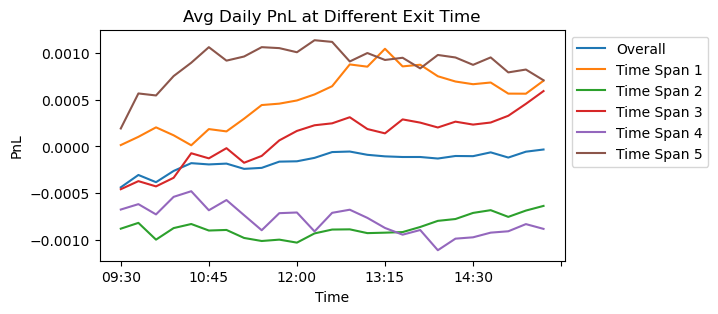

In [43]:
pnl_exit_sum = pd.DataFrame()
pnl_exit_sum['Overall'] = pnl_exit.groupby('Date').mean().mean()
pnl_exit_sum['Time Span 1'] = pnl_exit.loc[:'2011-12-31'].groupby('Date').mean().mean()
pnl_exit_sum['Time Span 2'] = pnl_exit.loc['2012-01-01':'2015-12-31'].groupby('Date').mean().mean()
pnl_exit_sum['Time Span 3'] = pnl_exit.loc['2016-01-01':'2017-12-31'].groupby('Date').mean().mean()
pnl_exit_sum['Time Span 4'] = pnl_exit.loc['2018-01-01':'2020-05-31'].groupby('Date').mean().mean()
pnl_exit_sum['Time Span 5'] = pnl_exit.loc['2020-06-01':].groupby('Date').mean().mean()

pnl_exit_sum.plot(figsize=(6,3))
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('PnL')
plt.title('Avg Daily PnL at Different Exit Time')
plt.show()